# Models

<a id='contents'></a>
## Contents

* [Data](#data)
* [Setup and loading data](#setup_and)
* [Filtering and train/test split](#filtering)
* [Creating an instance of a classifier](#creating_an)
* [A first model (XGBoost)](#first_model)
* [Partial grid search](#partial_grid)
* [Saving/loading results](#savingloading)
* [Final model](#final_model)
* [Evaluation](#evaluation)
* [Feature importance](#feature_importance)
* [Other classifiers](#other_classifiers)

<a id='data'></a>
## Data
↑↑ [Contents](#contents) ↓ [Setup and loading data](#setup_and) 

SOCIÉTÉ DE L'ASSURANCE AUTOMOBILE DU QUÉBEC (SAAQ). Rapports d'accident, [Jeu de données], dans Données Québec, 2017, mis à jour le 18 decembre 2023. https://www.donneesquebec.ca/recherche/dataset/rapports-d-accident.

_Données issues des rapports d’accident remplis par les policiers, incluant notamment le moment, la gravité de l’accident de même que le type des véhicules impliqués._

QUEBEC AUTOMOBILE INSURANCE SOCIETY (SAAQ). Accident reports, [Dataset], in Data Quebec, 2017, updated December 18, 2023. https://www.donneesquebec.ca/recherche/dataset/rapports-d-accident, (accessed March 13, 2024).

_Data from accident reports completed by police officers, including the time, severity of the accident as well as the type of vehicles involved._

<a id='setup_and'></a>
## Setup and loading data
↑↑ [Contents](#contents) ↑ [Data](#data) ↓ [Filtering and train/test split](#filtering)

In [14]:
import os
from pathlib import Path
import sys

# If we're using Google Colab, we set the environment variable to point to the relevant folder in our Google Drive:
if 'COLAB_GPU' in os.environ:
    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['ROAD_SAFETY'] = '/content/drive/MyDrive/Colab Notebooks/road-safety'

# Otherwise, we use the environment variable on our local system:
project_environment_variable = "ROAD_SAFETY"

# Path to the root directory of the project:
project_path = Path(os.environ.get("ROAD_SAFETY"))

# Relative path to /scripts (from where custom modules will be imported):
scripts_path = project_path.joinpath("scripts")

# Add this path to sys.path so that Python will look there for modules:
sys.path.append(str(scripts_path))

# Now import path_step from our custom utils module to create a dictionary to all subdirectories in our root directory:
from utils import path_setup
path = path_setup.subfolders(base_path = project_path)


DICTIONARY 'PATH' CONTAINS PATHS TO SUBDIRECTORIES

path['project'] : D:\projects\road-safety
path['data'] : D:\projects\road-safety\data
path['expository'] : D:\projects\road-safety\expository
path['literature'] : D:\projects\road-safety\literature
path['notebooks'] : D:\projects\road-safety\notebooks
path['scripts'] : D:\projects\road-safety\scripts
path['models'] : D:\projects\road-safety\models
path['presentation'] : D:\projects\road-safety\presentation
path['streamlit'] : D:\projects\road-safety\streamlit


In [15]:
# Load csv files into one big dataframe
from processing import primary

data_dir: Path = path["data"]                 # Path to directory containing csv files
years: list = list(range(1999,2024))          # We want all data for years in this list, which does not have to be a subset of the years for which we actually hve data.
filename_format: str = "saaq_yyyy.csv"        # Or: "saaq_yyyy_fr.csv" (French version); "ncdb_yyyy.csv" (Canada-wide dataset).
Print: bool = False                           # If True, print value-count summary of dataframe.

saaq = primary(data_dir=data_dir,
               years=years,
               filename_format=filename_format,
               Print=Print,)


FOR EACH YEAR WE

  1. Read csv into dataframe.
  2. Replace strings 'x' by x if x is a number. May take a minute.
  3. Concatenate resulting dataframe with previous years' dataframe.

2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 
SOURCE DATAFRAME: self.df


<a id='filtering'></a>
## Filtering and train/test split
↑↑ [Contents](#contents) ↑ [Setup and loading data](#setup_and) ↓ [Creating an instance of a classifier](#creating_an)

In [141]:
from typing import Type, Union
import pandas as pd

source: Type[primary] = saaq                            # Source data.
restrict_to: Union[list, None] = {"REGION" :            # Remove all records *unless* column k lies in list v, for k : v in restrict_to dictionary.
                                 ["Montréal (06)",],}    
    
remove_if: Union[list,None] = None                      # Remove all records if column k lies in list v, for k : v in remove_if dictionary.    
drop_row_if_missing_value_in: Union[list, None] = None  # We drop all rows for which there is a missing value (i.e. sentinel value, if applicable) in a column from this list.   
                                                        # Should include targets in this list (no point having missing target values). 
                                                        # Also, any column in "stratify_by" below, otherwise the stratified train-test-split will throw an error (TypeError: '<' not supported between instances of 'float' and 'str') if the values are strings.
targets: list = ["TNRY_SEV"]                            # We intend to make predictions for values in each of these columns.
                                                        # Can add 'MULT_VEH', 'VICTIMS', and 'TNRY_SEV' to targets (saaq data): columns will be inserted automatically.
                                                        # Can add 'MULT_VEH', 'VICTIMS' to targets (ncdb data).
non_features: list = ["YEAR"]                           # Can add "ID" etc. here but "ID" and any target will automatically be removed from features 
features: list = [c for c in saaq.df.columns            # These are the features we will want to use to make predictions about the targets.
                    if c not in non_features]            
                  
test_size: float = 0.15                                 # We'll partition what's left of the rows into train/test sets, with this as relative test set size.
                                                        # We'll also split the 'train' set later, either through k-fold cross-validation or, if not, train will be split 90/10 with the 10% share going to validation.
seed: int = 0                                           # Wherever there is randomness (e.g. during train/test split we'll shuffle), we'll use this seed.
stratify: bool = True                                   # If True, we'll perform a stratified train/test split. Also applies to k-fold cross-validation (if applicable).
stratify_by: Union[list, None] = targets                # If stratify is True, we'll stratify train/test split so that proportions are maintained for tuples of values from columns in this list.

In [142]:
from processing import process

mtl_3sev = process(source=source,
                   restrict_to=restrict_to,
                   remove_if=remove_if,
                   drop_row_if_missing_value_in=drop_row_if_missing_value_in,
                   targets=targets,
                   features=features,
                   test_size=test_size,
                   seed=seed,
                   stratify=stratify,
                   stratify_by=stratify_by)

Removing ID from self.features

Removing all records unless:
  REGION in ['Montréal (06)']

Inserting 'TNRY_SEV' column.

Removing REGION from self.features (but not from self.df) as the number of distinct non-null values in self.df['REGION'] is 1.

Removing SEVERITY from self.features (but not from self.df): can't use SEVERITY to predict TNRY_SEV.

Removing NUM_VICTIMS from self.features (but not from self.df): can't use NUM_VICTIMS to predict TNRY_SEV.

Partitioning data into training/test sets: self.df_train/self.df_test.

self.ordinal_features = ['NUM_VEH', 'LIGHT', 'SPD_LIM']

self.ordinal_targets = ['TNRY_SEV']

self.categorical_features = ['LT_TRK', 'ZONE', 'RD_CONFG', 'WKDY_WKND', 'PED', 'HOUR', 'PUB_PRIV_RD', 'RDWX', 'WEATHER', 'MTRCYC', 'LONG_LOC', 'ACCDN_TYPE', 'RD_COND', 'ASPECT', 'BICYC', 'MONTH', 'HVY_VEH']

self.categorical_targets = []


<a id='creating_an'></a>
## Creating an instance of a classifier
↑↑ [Contents](#contents) ↑ [Filtering and train/test split](#filtering) ↓ [A first model (XGBoost)](#first_model)

In [167]:
from models import model
from typing import Optional, Type, Union, Callable
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

data: Type[process] = mtl_3sev    
folds: Union[int, None] = 5 
impute_strategy: Union[dict, None] = None #{'categorical': 'most_frequent', 'ordinal': 'most_frequent', 'constant' : -1}
classifier: Union[DecisionTreeClassifier,
                  GradientBoostingClassifier,
                  LogisticRegression, 
                  RandomForestClassifier, 
                  XGBClassifier,] = XGBClassifier(objective='multi:softmax', # 'binary:logistic', if two classes
                                                  eval_metric='mlogloss', # 'logloss', if two classes
                                                  max_delta_step=1,                                                   
                                                  importance_type='weight', 
                                                  max_depth = 3, 
                                                  n_estimators = 100, 
                                                  nthread=-1,)
balance: Union[int, None] = 95
filename_stem: str = "mtl_3sev"
model_dir: Path = path["models"]    

In [166]:
import importlib

import models

importlib.reload(models)

<module 'models' from 'D:\\projects\\road-safety\\scripts\\models.py'>

<a id='first_model'></a>
## A first model (XGBoost)
↑↑ [Contents](#contents) ↑ [Creating an instance of a classifier](#creating_an) ↓ [Partial grid search](#partial_grid)


SEPARATING FEATURES FROM TARGETS

self.X_train/self.X_test, self.y_train/self.y_test

MAPPING ORDINAL FEATURE/TARGET CODES

NUM_VEH: {1: 0, 2: 1, 9: 2}
LIGHT: {1: 3, 2: 2, 3: 1, 4: 0}
SPD_LIM: {'<50': 0, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9, 100: 10}
TNRY_SEV: {0: 0, 1: 1, 2: 2}

MAPPING CATEGORICAL FEATURE/TARGET CODES

LT_TRK: {'N': 0, 'Y': 1}
ZONE: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 9: 6}
RD_CONFG: {1: 0, 23: 1, 45: 2, 9: 3}
WKDY_WKND: {'WKDY': 0, 'WKND': 1}
PED: {'N': 0, 'Y': 1}
HOUR: {'00:00:00-03:59:00': 0, '04:00:00-07:59:00': 1, '08:00:00-11:59:00': 2, '12:00:00-15:59:00': 3, '16:00:00-19:59:00': 4, '20:00:00-23:59:00': 5}
PUB_PRIV_RD: {1: 0, 2: 1}
RDWX: {'N': 0, 'Y': 1}
WEATHER: {11: 0, 12: 1, 13: 2, 14: 3, 15: 4, 16: 5, 17: 6, 18: 7, 19: 8, 99: 9}
MTRCYC: {'N': 0, 'Y': 1}
LONG_LOC: {12: 0, 33: 1, 34: 2, 40: 3, 69: 4, 99: 5}
ACCDN_TYPE: {'vehicle': 0, 'pedestrian': 1, 'cyclist': 2, 'animal': 3, 'fixed object': 4, 'no collision': 5, 'other': 6}
RD_COND: {11: 0, 12: 1, 13: 2, 14

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2],
                                                                             [0,
                                                                              1,
                                                                              2,
                                                                              3],
                                                                             [0,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10]],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['NUM_VEH', 'LIGHT',
                                                   'SPD_LIM']),
                                                 ('onehot',
                                                  OneHotEncoder(categories=[[0,
                                                                             1],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5],
                                                                            [0,
                                                                             1],
                                                                            [0,...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type='weight',
                               interaction_constraints=None, learning_rate=None,
                 


       MAKING PREDICTIONS ON VALIDATION FOLD

CV 1:  FOLDING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 2:  FOLDING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 3:  FOLDING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 4:  FOLDING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

Target, prediction, and probabilities for each validation fold stored in self.preds dictionary.

Feature importances corresponding to each validation fold stored in self.feature_importances dictionary.

SAVING PIPELINE: D:\projects\road-safety\models\mtl_3sev_xgb.joblib

Metrics (including confusion matrices) contained in dictionary self.eval.
Metrics (excluding confusion matrices) also contained in dataframe self.eval_df

EVALUATION METRICS FOR EACH FOLD


,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.690437,0.605245,0.690437,0.690437,0.690437,0.690437,0.300967,0.817792
1,0.689690,0.627718,0.689690,0.689690,0.689690,0.689690,0.305113,0.819209
2,0.689903,0.611881,0.689903,0.689903,0.689903,0.689903,0.301137,0.820376
3,0.691487,0.628183,0.691487,0.691487,0.691487,0.691487,0.307360,0.819906
4,0.692052,0.617310,0.692052,0.692052,0.692052,0.692052,0.303823,0.817502
mean,0.690714,0.618067,0.690714,0.690714,0.690714,0.690714,0.303680,0.818957



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Feature importances corresponding to validation set(s) contained in self.feature_importances and self.feature_importances_df.

FEATURE IMPORTANCE


interactive(children=(Dropdown(description='Sort by:', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_clas…

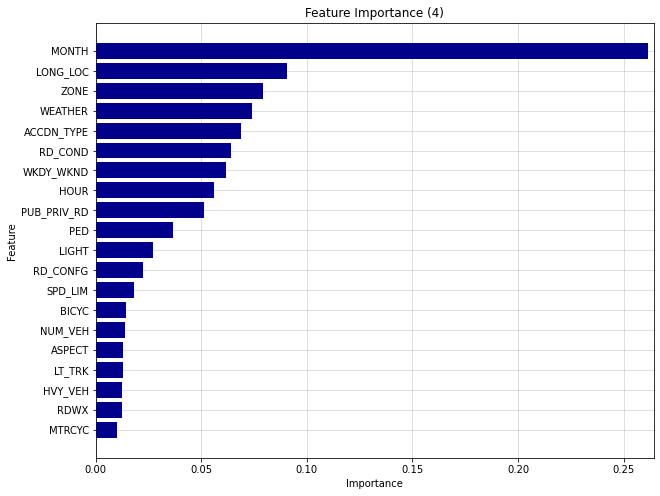

In [168]:
mtl_3sev_xgb = model(data=data,    
                     folds=folds, 
                     impute_strategy=impute_strategy, 
                     classifier=classifier,
                     balance=balance,
                     filename_stem=filename_stem,
                     model_dir=model_dir,)

In [192]:
new_data

{'MONTH': 1,
 'HOUR': 2,
 'WKDY_WKND': 0,
 'NUM_VEH': 2,
 'SPD_LIM': 8,
 'ACCDN_TYPE': 1,
 'RD_COND': 3,
 'LIGHT': 3,
 'ZONE': 4,
 'PUB_PRIV_RD': 1,
 'ASPECT': 0,
 'LONG_LOC': 0,
 'RD_CONFG': 0,
 'RDWX': 1,
 'WEATHER': 4,
 'LT_TRK': 1,
 'HVY_VEH': 0,
 'MTRCYC': 1,
 'BICYC': 1,
 'PED': 0}

<a id='partial_grid'></a>
## Partial grid search
↑↑ [Contents](#contents) ↑ [A first model (XGBoost)](#first_model) ↓ [Saving/loading results](#savingloading)

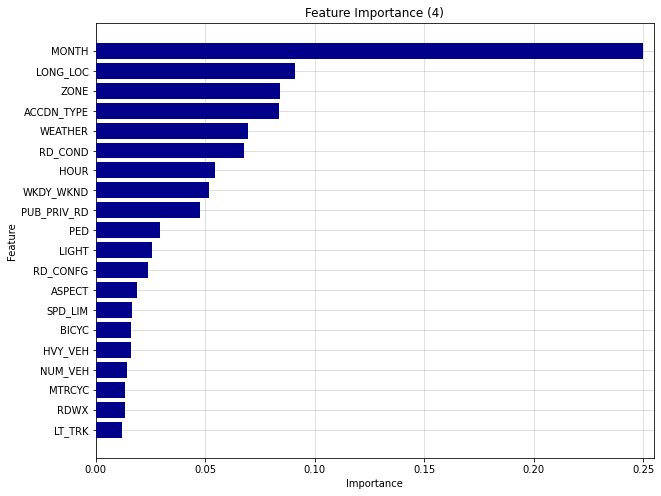

In [164]:
from utils import clear_output
from models import save_gs_items, load_gs_items

filename = 'mtl_3sev_gs'
try:
    mtl_3sev_gs = load_gs_items(model_dir=model_dir, filename=filename)
except:
    mtl_3sev_gs = {}

max_depth = 3
n_estimators = 150

for balance in [5*i for i in range(15,19)]:
    key = str((balance, max_depth, n_estimators))
    if key in mtl_3sev_gs.keys():
        pass
    else:
        print("\n" + "="*50 + f"\n(balance, max_depth, n_estimators) = ({balance}, {max_depth}, {n_estimators})\n" + "="*50 + "\n")
        mtl_3sev_gs[key] = models.custom_xgb_grid_search(data=data,    
                                                         folds=folds, 
                                                         impute_strategy=impute_strategy, 
                                                         balance=balance,
                                                         filename_stem="xgb_gs",
                                                         model_dir=model_dir,    
                                                         max_depth=max_depth, 
                                                         n_estimators=n_estimators,)
        clear_output()

save_gs_items(model_dir=model_dir,
              filename=filename,
              gs_dict=mtl_3sev_gs)

<a id='savingloading'></a>
## Saving/loading results
↑↑ [Contents](#contents) ↑ [Partial grid search](#partial_grid) ↓ [Final model](#final_model)

In [165]:
from models import load_gs_items, evaluation_df, confusion_matrix_widget

filename = 'mtl_3sev_gs'
gs_dict = load_gs_items(model_dir=model_dir, filename=filename)

for gs_parameters in gs_dict.keys():
    print("\n" + "="*51 + f"\n(balance, max_depth, n_estimators) = {gs_parameters}\n" + "="*51 + "\n")
    metrics = { k : v for k, v in gs_dict[gs_parameters]["evaluation"].items() if k != "confusion"}
    display(evaluation_df(metrics))
    metrics["confusion"] = []
    for d in gs_dict[gs_parameters]["evaluation"]["confusion"]:
        metrics["confusion"].append({k : pd.DataFrame(v).T for k, v in d.items()})
    confusion_matrix_widget(metrics)


(balance, max_depth, n_estimators) = (None, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.854849,0.450126,0.842478,0.854849,0.828721,0.841591,0.481615,0.843801
1,0.854279,0.451579,0.842824,0.854279,0.827628,0.840736,0.478932,0.844434
2,0.855953,0.453239,0.844415,0.855953,0.830089,0.842775,0.486516,0.845408
3,0.855401,0.448354,0.843283,0.855401,0.828570,0.841754,0.483662,0.843803
4,0.855487,0.450496,0.843455,0.855487,0.829099,0.842067,0.484229,0.840915
mean,0.855194,0.450759,0.843291,0.855194,0.828821,0.841785,0.482991,0.843672



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (10, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.756640,0.508753,0.816495,0.756640,0.773973,0.759985,0.413088,0.842649
1,0.755358,0.509643,0.816382,0.755358,0.773194,0.758826,0.412386,0.842522
2,0.757316,0.510137,0.818026,0.757316,0.774909,0.760648,0.417916,0.844540
3,0.757548,0.509474,0.817361,0.757548,0.774965,0.760921,0.415777,0.842799
4,0.756386,0.506875,0.816013,0.756386,0.773766,0.759770,0.412201,0.839647
mean,0.756650,0.508976,0.816856,0.756650,0.774162,0.760030,0.414273,0.842431



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (20, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.755109,0.528882,0.815307,0.755109,0.773964,0.759384,0.408105,0.840431
1,0.753685,0.528551,0.816119,0.753685,0.773083,0.758003,0.408779,0.840448
2,0.754860,0.532658,0.817001,0.754860,0.774225,0.759202,0.411255,0.842626
3,0.754165,0.530463,0.816462,0.754165,0.773438,0.758413,0.409872,0.840940
4,0.753200,0.532407,0.815234,0.753200,0.772552,0.757547,0.406452,0.837737
mean,0.754204,0.530592,0.816025,0.754204,0.773452,0.758510,0.408892,0.840436



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (30, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.748344,0.544618,0.813793,0.748344,0.769804,0.753722,0.397337,0.837874
1,0.749893,0.547913,0.814987,0.749893,0.771229,0.755233,0.400424,0.838842
2,0.749430,0.541371,0.815932,0.749430,0.771252,0.754907,0.401550,0.839889
3,0.749822,0.545800,0.814489,0.749822,0.771180,0.755246,0.399049,0.838288
4,0.749194,0.548888,0.813367,0.749194,0.770326,0.754529,0.396810,0.834816
mean,0.749337,0.545718,0.814513,0.749337,0.770758,0.754727,0.399034,0.837942



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (40, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.744054,0.561248,0.813096,0.744054,0.767916,0.750595,0.388252,0.835829
1,0.743574,0.557841,0.813298,0.743574,0.767505,0.750067,0.388321,0.836263
2,0.744482,0.560845,0.814595,0.744482,0.768576,0.751030,0.391333,0.837470
3,0.744072,0.559327,0.814159,0.744072,0.768020,0.750523,0.390814,0.836464
4,0.744441,0.566500,0.812695,0.744441,0.768025,0.750901,0.387787,0.833039
mean,0.744125,0.561152,0.813569,0.744125,0.768008,0.750623,0.389301,0.835813



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (50, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.737183,0.571310,0.811536,0.737183,0.763963,0.744934,0.375434,0.833995
1,0.737023,0.571342,0.812466,0.737023,0.763997,0.744757,0.377227,0.834257
2,0.738233,0.566312,0.812563,0.738233,0.765044,0.746019,0.377629,0.834733
3,0.737450,0.566319,0.812868,0.737450,0.764434,0.745202,0.378484,0.834179
4,0.738460,0.575157,0.811988,0.738460,0.764672,0.745940,0.378375,0.831778
mean,0.737670,0.570088,0.812284,0.737670,0.764422,0.745370,0.377430,0.833788



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (60, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.729956,0.581486,0.809886,0.729956,0.759845,0.738954,0.362220,0.831342
1,0.731344,0.580996,0.811588,0.731344,0.760966,0.740139,0.367326,0.832443
2,0.731024,0.573506,0.811150,0.731024,0.760977,0.740067,0.364909,0.832967
3,0.730828,0.578574,0.811283,0.730828,0.760656,0.739733,0.366179,0.832280
4,0.731518,0.585310,0.810208,0.731518,0.760662,0.740190,0.365073,0.830062
mean,0.730934,0.579974,0.810823,0.730934,0.760621,0.739817,0.365141,0.831819



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (70, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.723476,0.583189,0.808792,0.723476,0.756099,0.733511,0.351875,0.829503
1,0.722746,0.583516,0.810107,0.722746,0.755868,0.732847,0.354035,0.830466
2,0.723601,0.578963,0.809891,0.723601,0.756705,0.733839,0.352881,0.831357
3,0.724206,0.582252,0.809869,0.724206,0.756930,0.734269,0.354377,0.830051
4,0.726142,0.587175,0.810694,0.726142,0.758216,0.735917,0.358327,0.828094
mean,0.724034,0.583019,0.809871,0.724034,0.756764,0.734076,0.354299,0.829894



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (80, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.719293,0.583118,0.808603,0.719293,0.754168,0.730236,0.345136,0.827973
1,0.718581,0.587812,0.809532,0.718581,0.753653,0.729434,0.347465,0.828384
2,0.717192,0.585967,0.808601,0.717192,0.753023,0.728459,0.342265,0.829691
3,0.718634,0.588305,0.808559,0.718634,0.753702,0.729597,0.344725,0.828463
4,0.721050,0.586538,0.808791,0.721050,0.755085,0.731649,0.347867,0.826578
mean,0.718950,0.586348,0.808817,0.718950,0.753926,0.729875,0.345492,0.828218



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (90, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.714896,0.583795,0.807925,0.714896,0.751720,0.726584,0.338269,0.826389
1,0.714558,0.590400,0.808547,0.714558,0.751612,0.726242,0.339481,0.826644
2,0.713792,0.585109,0.807503,0.713792,0.751046,0.725651,0.335610,0.827839
3,0.712244,0.591446,0.808207,0.712244,0.750238,0.724262,0.336448,0.827485
4,0.713858,0.594969,0.807882,0.713858,0.750767,0.725425,0.338423,0.825051
mean,0.713870,0.589144,0.808013,0.713870,0.751077,0.725633,0.337646,0.826682



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (70, 3, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.708238,0.602734,0.804331,0.708238,0.746343,0.720222,0.325940,0.823425
1,0.710036,0.617587,0.806795,0.710036,0.747953,0.721762,0.332792,0.824704
2,0.710161,0.606543,0.805410,0.710161,0.748075,0.722103,0.328455,0.826023
3,0.710802,0.617635,0.806400,0.710802,0.748554,0.722552,0.332175,0.824906
4,0.711277,0.610211,0.805606,0.711277,0.748457,0.722872,0.331570,0.822695
mean,0.710103,0.610942,0.805708,0.710103,0.747876,0.721902,0.330186,0.824351



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (80, 3, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.699391,0.598407,0.802524,0.699391,0.741166,0.712772,0.312069,0.820979
1,0.702346,0.623279,0.805231,0.702346,0.743595,0.715297,0.320344,0.821901
2,0.701438,0.609830,0.802791,0.701438,0.742527,0.714526,0.313852,0.822716
3,0.702026,0.625940,0.805107,0.702026,0.743389,0.715003,0.320039,0.822355
4,0.702750,0.617724,0.804001,0.702750,0.743364,0.715539,0.318938,0.820459
mean,0.701590,0.615036,0.803931,0.701590,0.742808,0.714628,0.317048,0.821682



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (90, 3, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.691470,0.606722,0.801415,0.691470,0.736409,0.705892,0.302266,0.818423
1,0.692965,0.621299,0.803681,0.692965,0.737985,0.707261,0.307620,0.819995
2,0.692235,0.610988,0.801547,0.692235,0.737235,0.706705,0.301468,0.820866
3,0.693891,0.626903,0.804162,0.693891,0.738911,0.708186,0.308987,0.820676
4,0.692906,0.613600,0.802556,0.692906,0.737607,0.707181,0.305618,0.818261
mean,0.692693,0.615902,0.802672,0.692693,0.737629,0.707045,0.305192,0.819644



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (75, 2, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.701777,0.594896,0.798950,0.701777,0.741499,0.714587,0.307158,0.816535
1,0.701616,0.618251,0.801943,0.701616,0.741869,0.714277,0.313957,0.818382
2,0.699658,0.605493,0.799500,0.699658,0.740192,0.712594,0.306579,0.818260
3,0.702471,0.615023,0.801605,0.702471,0.742541,0.715163,0.313438,0.818465
4,0.703712,0.614436,0.801177,0.703712,0.742987,0.716128,0.314271,0.816091
mean,0.701847,0.609620,0.800635,0.701847,0.741818,0.714550,0.311081,0.817547



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (80, 2, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.695884,0.598596,0.798868,0.695884,0.737935,0.709406,0.301777,0.815535
1,0.697433,0.617150,0.800232,0.697433,0.739250,0.710715,0.305686,0.816600
2,0.696365,0.606165,0.798641,0.696365,0.738349,0.709854,0.300695,0.817231
3,0.699587,0.616308,0.800862,0.699587,0.740976,0.712785,0.308154,0.816865
4,0.697873,0.614225,0.798959,0.697873,0.739185,0.711051,0.303539,0.814534
mean,0.697428,0.610489,0.799513,0.697428,0.739139,0.710762,0.303970,0.816153



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (85, 2, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.691274,0.596490,0.798357,0.691274,0.735238,0.705479,0.296359,0.813823
1,0.693018,0.619848,0.799945,0.693018,0.736671,0.706897,0.300905,0.815644
2,0.690117,0.605558,0.798349,0.690117,0.734563,0.704405,0.294687,0.815765
3,0.697095,0.619956,0.800307,0.697095,0.739574,0.710670,0.304044,0.815763
4,0.691838,0.610522,0.798596,0.691838,0.735604,0.705857,0.297176,0.813525
mean,0.692668,0.610475,0.799111,0.692668,0.736330,0.706662,0.298634,0.814904



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (90, 2, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.687215,0.598230,0.797658,0.687215,0.732661,0.701903,0.291432,0.813162
1,0.687874,0.618013,0.798502,0.687874,0.733432,0.702446,0.292879,0.814379
2,0.687251,0.608355,0.798312,0.687251,0.732964,0.701946,0.291853,0.814657
3,0.691719,0.623113,0.799991,0.691719,0.736226,0.705908,0.299085,0.814848
4,0.686943,0.610714,0.798614,0.686943,0.732706,0.701601,0.293064,0.812452
mean,0.688200,0.611685,0.798615,0.688200,0.733598,0.702761,0.293662,0.813900



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (75, 3, 150)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.704749,0.599944,0.804568,0.704749,0.744618,0.717382,0.322130,0.823750
1,0.708790,0.621082,0.807081,0.708790,0.747927,0.721035,0.330028,0.825206
2,0.706886,0.606350,0.805283,0.706886,0.746227,0.719322,0.324638,0.825948
3,0.706494,0.619899,0.806494,0.706494,0.746119,0.718848,0.328066,0.824821
4,0.709426,0.611637,0.805473,0.709426,0.747642,0.721428,0.328556,0.822782
mean,0.707269,0.611782,0.805780,0.707269,0.746507,0.719603,0.326684,0.824501



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (80, 3, 150)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.701421,0.602175,0.804610,0.701421,0.742876,0.714603,0.318511,0.822556
1,0.702827,0.622761,0.806098,0.702827,0.744150,0.715791,0.322570,0.823547
2,0.702222,0.613093,0.803987,0.702222,0.743191,0.715189,0.317433,0.824201
3,0.703557,0.624591,0.806414,0.703557,0.744875,0.716548,0.323604,0.823746
4,0.704815,0.616962,0.805102,0.704815,0.744983,0.717460,0.322876,0.821759
mean,0.702968,0.615916,0.805242,0.702968,0.744015,0.715918,0.320999,0.823162



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (85, 3, 150)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.698074,0.606349,0.803246,0.698074,0.740778,0.711725,0.311926,0.820952
1,0.698590,0.623544,0.805932,0.698590,0.741813,0.712213,0.317497,0.822921
2,0.697842,0.610486,0.803368,0.697842,0.740723,0.711525,0.311192,0.823279
3,0.698519,0.620378,0.805128,0.698519,0.741776,0.712249,0.315531,0.822805
4,0.698905,0.613848,0.804202,0.698905,0.741504,0.712439,0.314754,0.820683
mean,0.698386,0.614921,0.804375,0.698386,0.741319,0.712030,0.314180,0.822128



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (90, 3, 150)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.694104,0.604534,0.802894,0.694104,0.738574,0.708404,0.307105,0.820131
1,0.695706,0.624280,0.805104,0.695706,0.740112,0.709775,0.312546,0.821939
2,0.693659,0.611461,0.802489,0.693659,0.738239,0.707952,0.305044,0.822284
3,0.694709,0.622849,0.805897,0.694709,0.739927,0.709077,0.313025,0.821946
4,0.695256,0.614236,0.804325,0.695256,0.739534,0.709362,0.311276,0.819654
mean,0.694687,0.615472,0.804142,0.694687,0.739277,0.708914,0.309799,0.821191



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()

In [ ]:
print("\n" + "="*60 + "\nMetrics for *trivial prediction* (all labels majority class)".upper() + "\n" + "="*60)
display(mtl_3sev_xgb.triv_eval_df)

print("\n" + "="*71 + "\nConfusion matrices for *trivial prediction* (all labels majority class)".upper() + "\n" + "="*71)
model.confusion_matrix_widget(mtl_3sev_xgb, mtl_sev_xgb.triv_eval)

<a id='final_model'></a>
## Final model
↑↑ [Contents](#contents) ↑ [Saving/loading results](#savingloading) ↓ [Evaluation](#evaluation)

In [233]:
import joblib
import random
import pandas as pd

instance = mtl_3sev_xgb
trained = joblib.load(instance.filepath)
 
new_data = dict.fromkeys(instance.data.features)
for feature in new_data.keys():
    new_data[feature] = random.choice(list(instance.class_codes[feature].values()))

new_data_df = pd.DataFrame(new_data, columns = instance.data.features, index=[0])

predictions = trained.predict(new_data_df)
probabilities = trained.predict_proba(new_data_df)

In [243]:
predictions[0], probabilities[0,0]

(2, 0.003589866)

In [238]:
trained

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2],
                                                                             [0,
                                                                              1,
                                                                              2,
                                                                              3],
                                                                             [0,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10]],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['NUM_VEH', 'LIGHT',
                                                   'SPD_LIM']),
                                                 ('onehot',
                                                  OneHotEncoder(categories=[[0,
                                                                             1],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5],
                                                                            [0,
                                                                             1],
                                                                            [0,...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type='weight',
                               interaction_constraints=None, learning_rate=None,
                 

<a id='evaluation'></a>
## Evaluation
↑↑ [Contents](#contents) ↑ [Final model](#final_model) ↓ [Feature importance](#feature_importance)

<a id='feature_importance'></a>
## Feature importance
↑↑ [Contents](#contents) ↑ [Evaluation](#evaluation) ↓ [Other classifiers](#other_classifiers)

<a id='other_classifiers'></a>
## Other classifiers
↑↑ [Contents](#contents) ↑ [Feature importance](#feature_importance)

# Four-level severity

In [160]:
from models import load_gs_items, evaluation_df, confusion_matrix_widget

filename = 'mtl_sev_gs'
gs_dict = load_gs_items(model_dir=model_dir, filename=filename)

for gs_parameters in gs_dict.keys():
    print("\n" + "="*51 + f"\n(balance, max_depth, n_estimators) = {gs_parameters}\n" + "="*51 + "\n")
    metrics = { k : v for k, v in gs_dict[gs_parameters]["evaluation"].items() if k != "confusion"}
    display(evaluation_df(metrics))
    metrics["confusion"] = []
    for d in gs_dict[gs_parameters]["evaluation"]["confusion"]:
        metrics["confusion"].append({k : pd.DataFrame(v).T for k, v in d.items()})
    confusion_matrix_widget(metrics)


(balance, max_depth, n_estimators) = (None, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.606433,0.428014,0.621850,0.606433,0.597657,0.600493,0.366325,0.767977
1,0.604796,0.428285,0.620617,0.604796,0.596125,0.598891,0.363636,0.766789
2,0.605525,0.430480,0.622362,0.605525,0.596941,0.599675,0.364927,0.767853
3,0.604956,0.427050,0.623045,0.604956,0.595896,0.598735,0.363472,0.767126
4,0.604148,0.427863,0.619937,0.604148,0.595295,0.598137,0.362482,0.766481
mean,0.605172,0.428338,0.621562,0.605172,0.596383,0.599186,0.364168,0.767246



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (10, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.580693,0.473865,0.586900,0.580693,0.580815,0.580005,0.360415,0.762701
1,0.578272,0.463987,0.583965,0.578272,0.578494,0.577707,0.356004,0.760667
2,0.579571,0.477052,0.586270,0.579571,0.579919,0.578960,0.358908,0.762525
3,0.579340,0.472599,0.584756,0.579340,0.579508,0.578766,0.357181,0.761848
4,0.579671,0.473327,0.585334,0.579671,0.580102,0.579241,0.357491,0.760681
mean,0.579509,0.472166,0.585445,0.579509,0.579767,0.578936,0.358000,0.761684



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (20, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.570973,0.490260,0.583287,0.570973,0.574156,0.571508,0.348943,0.759119
1,0.568090,0.488104,0.579990,0.568090,0.571396,0.568743,0.343903,0.756904
2,0.570475,0.503596,0.583191,0.570475,0.573990,0.571145,0.348235,0.758825
3,0.572451,0.496199,0.583014,0.572451,0.575248,0.572942,0.349674,0.758468
4,0.570414,0.494495,0.582482,0.570414,0.574025,0.571226,0.347074,0.757359
mean,0.570481,0.494531,0.582393,0.570481,0.573763,0.571113,0.347566,0.758135



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (30, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.559011,0.499729,0.578576,0.559011,0.565625,0.560704,0.334736,0.755741
1,0.556305,0.500861,0.576662,0.556305,0.563392,0.558164,0.330981,0.752989
2,0.559296,0.516242,0.579633,0.559296,0.566276,0.561049,0.335472,0.755535
3,0.559990,0.510107,0.579064,0.559990,0.566605,0.561704,0.335604,0.755266
4,0.558291,0.519179,0.578553,0.558291,0.565366,0.560078,0.333769,0.753380
mean,0.558579,0.509224,0.578497,0.558579,0.565453,0.560340,0.334112,0.754582



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (40, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.548651,0.515437,0.575687,0.548651,0.558418,0.551187,0.323737,0.751470
1,0.545215,0.507098,0.574109,0.545215,0.556304,0.548332,0.319182,0.749447
2,0.548241,0.519655,0.576262,0.548241,0.558694,0.551036,0.323264,0.752046
3,0.548989,0.517325,0.576332,0.548989,0.559225,0.551763,0.324181,0.751476
4,0.545723,0.522451,0.575056,0.545723,0.556903,0.548744,0.320261,0.749770
mean,0.547364,0.516393,0.575489,0.547364,0.557909,0.550212,0.322125,0.750842



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


(balance, max_depth, n_estimators) = (50, 6, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.538112,0.514634,0.573330,0.538112,0.551208,0.541594,0.313541,0.748272
1,0.533804,0.511575,0.570640,0.533804,0.548220,0.537859,0.307802,0.746199
2,0.539394,0.526264,0.574901,0.539394,0.552814,0.542959,0.315452,0.748758
3,0.537650,0.522997,0.572982,0.537650,0.551122,0.541283,0.312952,0.748261
4,0.535719,0.528577,0.572014,0.535719,0.549669,0.539430,0.310268,0.746462
mean,0.536936,0.520809,0.572773,0.536936,0.550607,0.540625,0.312003,0.747590



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()

In [ ]:
mtl_sev_xgb = model(data=data, 
                    folds = folds,
                    impute_strategy=impute_strategy,
                    classifier=classifier,
                    balance=balance,
                    filename_stem=filename_stem,
                    model_dir=model_dir,)

In [5]:
from sklearn.model_selection import GridSearchCV

# This is just an example. Will do more extensive grid search.

data: Type[process] = mtl_sev    
folds: Union[int,None] = 3
impute_strategy: Union[dict, None] = None #{'categorical': 'most_frequent', 'ordinal': 'constant', 'constant' : -1}
classifier: Union[DecisionTreeClassifier,
                  LogisticRegression, 
                  RandomForestClassifier,
                  XGBClassifier,] = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', nthread=-1)
grid_search_scoring: Union[None, str, Callable] = 'matthews_corrcoef' 
param_grid: dict = {
    'classifier__learning_rate': [0.1, 0.3],
    'classifier__max_depth': [3, 6],
    'classifier__min_child_weight': [1, 3],
}   
    
mtl_sev_xgb_gs = model(data=data, 
                    folds = folds,
                    impute_strategy=impute_strategy,
                    classifier=classifier,
                    grid_search_scoring=grid_search_scoring,
                    param_grid=param_grid,)


SEPARATING FEATURES FROM TARGETS

self.X_train/self.X_test, self.y_train/self.y_test

MAPPING ORDINAL FEATURE/TARGET CODES

SPD_LIM: {'<50': 0, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9, 100: 10}
LIGHT: {1: 3, 2: 2, 3: 1, 4: 0}
NUM_VEH: {1: 0, 2: 1, 9: 2}
SEVERITY: {'Material damage below the reporting threshold': 0, 'Material damage only': 1, 'Minor': 2, 'Fatal or serious': 3}

MAPPING CATEGORICAL FEATURE/TARGET CODES

PED: {'N': 0, 'Y': 1}
HOUR: {'00:00:00-03:59:00': 0, '04:00:00-07:59:00': 1, '08:00:00-11:59:00': 2, '12:00:00-15:59:00': 3, '16:00:00-19:59:00': 4, '20:00:00-23:59:00': 5}
ACCDN_TYPE: {'vehicle': 0, 'pedestrian': 1, 'cyclist': 2, 'animal': 3, 'fixed object': 4, 'no collision': 5, 'other': 6}
PUB_PRIV_RD: {1: 0, 2: 1}
BICYC: {'N': 0, 'Y': 1}
MONTH: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
RD_CONFG: {1: 0, 23: 1, 45: 2, 9: 3}
MTRCYC: {'N': 0, 'Y': 1}
WKDY_WKND: {'WKDY': 0, 'WKND': 1}
RDWX: {'N': 0, 'Y': 1}
WEATHER: {12: 0, 13: 1, 14: 2, 15:

KeyboardInterrupt: 


SEPARATING FEATURES FROM TARGETS

self.X_train/self.X_test, self.y_train/self.y_test

MAPPING ORDINAL FEATURE/TARGET CODES

LIGHT: {1: 3, 2: 2, 3: 1, 4: 0}
SPD_LIM: {'<50': 0, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9, 100: 10}
NUM_VEH: {1: 0, 2: 1, 9: 2}
SEVERITY: {'Material damage below the reporting threshold': 0, 'Material damage only': 1, 'Minor': 2, 'Fatal or serious': 3}

MAPPING CATEGORICAL FEATURE/TARGET CODES

HOUR: {'00:00:00-03:59:00': 0, '04:00:00-07:59:00': 1, '08:00:00-11:59:00': 2, '12:00:00-15:59:00': 3, '16:00:00-19:59:00': 4, '20:00:00-23:59:00': 5}
WEATHER: {12: 0, 13: 1, 14: 2, 15: 3, 16: 4, 17: 5, 18: 6, 19: 7, 99: 8}
ASPECT: {'Straight': 0, 'Curve': 1}
WKDY_WKND: {'WKDY': 0, 'WKND': 1}
BICYC: {'N': 0, 'Y': 1}
PUB_PRIV_RD: {1: 0, 2: 1}
ACCDN_TYPE: {'vehicle': 0, 'pedestrian': 1, 'cyclist': 2, 'animal': 3, 'fixed object': 4, 'no collision': 5, 'other': 6}
LONG_LOC: {12: 0, 33: 1, 34: 2, 40: 3, 69: 4, 99: 5}
MONTH: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_imputer',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='most_frequent'),
                                                  ['LIGHT', 'SPD_LIM',
                                                   'NUM_VEH']),
                                                 ('categorical_imputer',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='most_frequent'),
                                                  ['HOUR', 'WEATHER', 'ASPECT',
                                                   'WKDY_WKND', 'BICYC',
                                                   'PUB_PRIV_RD', 'ACCDN_TYPE',
                                                   'LONG_L...
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                       


      MAKING PREDICTIONS ON VALIDATION FOLD

CV 1: IMPUTING MISSING VALUES AND FITTING

      MAKING PREDICTIONS ON VALIDATION FOLD

CV 2: IMPUTING MISSING VALUES AND FITTING

      MAKING PREDICTIONS ON VALIDATION FOLD

Target, prediction, and probabilities for each validation fold stored in self.preds dictionary.

Feature importances corresponding to each validation fold stored in self.feature_importances dictionary.

SAVING PIPELINE: D:\projects\road-safety\models\mtl_sev_lr.joblib

Metrics (including confusion matrices) contained in dictionary self.eval.
Metrics (excluding confusion matrices) also contained in dataframe self.eval_df


,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.595093,0.385275,0.612200,0.595093,0.562389,0.574160,0.313025,0.739425
1,0.590678,0.375883,0.604744,0.590678,0.555394,0.568378,0.303805,0.740600
2,0.598374,0.384036,0.616209,0.598374,0.565783,0.577207,0.319267,0.745009
mean,0.594715,0.381731,0.611051,0.594715,0.561188,0.573249,0.312032,0.741678



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2), value=0)

Output()


Feature importances corresponding to validation set(s) contained in self.feature_importances and self.feature_importances_df.

FEATURE IMPORTANCE


interactive(children=(Dropdown(description='Sort by:', options=(0, 1, 2), value=0), Output()), _dom_classes=('…

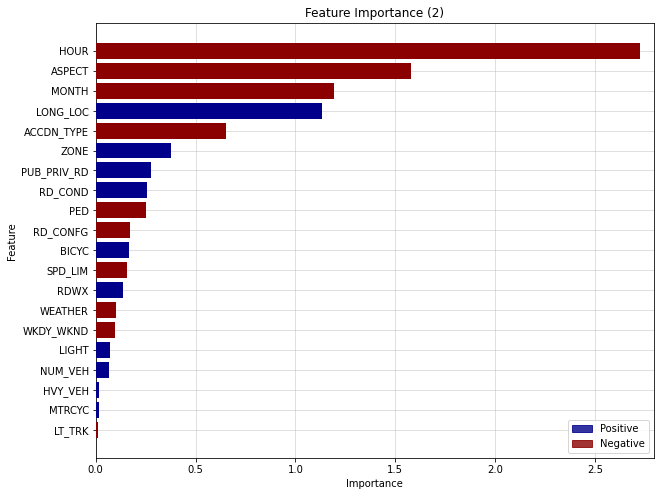

In [7]:
data: Type[process] = mtl_sev    
folds: Union[int,None] = 3
impute_strategy: Union[dict, None] = {'categorical': 'most_frequent', 'ordinal': 'most_frequent', 'constant' : -1}
classifier: Union[DecisionTreeClassifier,
                  LogisticRegression, 
                  RandomForestClassifier,
                  XGBClassifier,] = LogisticRegression(max_iter=1000, n_jobs=-1)
filename_stem: str = "mtl_sev"
model_dir: Path = path["models"]    
    
mtl_sev_lr = model(data=data, 
                    folds = folds,
                    impute_strategy=impute_strategy,
                    classifier=classifier,
                    filename_stem=filename_stem,
                    model_dir=model_dir,)

In [ ]:
# This would take quite a long time. 
# Reduce number of features or try on Google Colab where there might be multiple CPUs available.
data: Type[process] = mtl_sev    
folds: Union[int,None] = 3
impute_strategy: Union[dict, None] = {'categorical': 'most_frequent', 'ordinal': 'constant', 'constant' : -1}
classifier: Union[DecisionTreeClassifier,
                  LogisticRegression, 
                  RandomForestClassifier,
                  XGBClassifier,] = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
filename_stem: str = "mtl_sev"
model_dir: Path = path["models"]    
    
mtl_sev_rf = model(data=data, 
                    folds = folds,
                    impute_strategy=impute_strategy,
                    classifier=classifier,
                    filename_stem=filename_stem,
                    model_dir=model_dir,)


SEPARATING FEATURES FROM TARGETS

self.X_train/self.X_test, self.y_train/self.y_test

MAPPING ORDINAL FEATURE/TARGET CODES

NUM_VEH: {1: 0, 2: 1, 9: 2}
LIGHT: {1: 3, 2: 2, 3: 1, 4: 0}
SPD_LIM: {'<50': 0, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9, 100: 10}
SEVERITY: {'Material damage below the reporting threshold': 0, 'Material damage only': 1, 'Minor': 2, 'Fatal or serious': 3}

MAPPING CATEGORICAL FEATURE/TARGET CODES

MONTH: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
BICYC: {'N': 0, 'Y': 1}
WEATHER: {12: 0, 13: 1, 14: 2, 15: 3, 16: 4, 17: 5, 18: 6, 19: 7, 99: 8}
MTRCYC: {'N': 0, 'Y': 1}
ACCDN_TYPE: {'vehicle': 0, 'pedestrian': 1, 'cyclist': 2, 'animal': 3, 'fixed object': 4, 'no collision': 5, 'other': 6}
LONG_LOC: {12: 0, 33: 1, 34: 2, 40: 3, 69: 4, 99: 5}
LT_TRK: {'N': 0, 'Y': 1}
HOUR: {'00:00:00-03:59:00': 0, '04:00:00-07:59:00': 1, '08:00:00-11:59:00': 2, '12:00:00-15:59:00': 3, '16:00:00-19:59:00': 4, '20:00:00-23:59:00': 5}
RDWX: {'N': 0, 'Y': 1}
PU

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[[-1,
                                                                              0,
                                                                              1,
                                                                              2],
                                                                             [-1,
                                                                              0,
                                                                              1,
                                                                              2,
                                                                              3],
                                                                             [-1,
                                                                              0,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10]],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['NUM_VEH', 'LIGHT',
                                                   'SPD_LIM']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['MONTH', 'BICYC', 'WEATHER',
                                                   'MTRCYC', 'ACCDN_TYPE',
                                                   'LONG_LOC', 'LT_TRK', 'HOUR',
                                                   'RDWX', 'PUB_PRIV_RD', 'PED',
                                                   'HVY_VEH', 'ZONE',
                                                   'WKDY_WKND', 'RD_COND',
                                                   'ASPECT', 'RD_CONFG'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=0))])


      MAKING PREDICTIONS ON VALIDATION FOLD

CV 1: IMPUTING MISSING VALUES AND FITTING

      MAKING PREDICTIONS ON VALIDATION FOLD

CV 2: IMPUTING MISSING VALUES AND FITTING

      MAKING PREDICTIONS ON VALIDATION FOLD

Target, prediction, and probabilities for each validation fold stored in self.preds dictionary.

Feature importances corresponding to each validation fold stored in self.feature_importances dictionary.

SAVING PIPELINE: D:\projects\road-safety\models\mtl_sev_dt.joblib


C:\Users\Trismegistus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Trismegistus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Metrics (including confusion matrices) contained in dictionary self.eval.
Metrics (excluding confusion matrices) also contained in dataframe self.eval_df


,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.499542,0.366852,0.610668,0.499542,0.461479,0.465228,0.274039,0.631237
1,0.498788,0.365897,0.610616,0.498788,0.460119,0.464180,0.272292,0.629622
2,0.498457,0.365742,0.607622,0.498457,0.460178,0.464166,0.271196,0.629940
mean,0.498929,0.366164,0.609635,0.498929,0.460592,0.464525,0.272509,0.630267



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2), value=0)

Output()


Feature importances corresponding to validation set(s) contained in self.feature_importances and self.feature_importances_df.

FEATURE IMPORTANCE


interactive(children=(Dropdown(description='Sort by:', options=(0, 1, 2), value=0), Output()), _dom_classes=('…

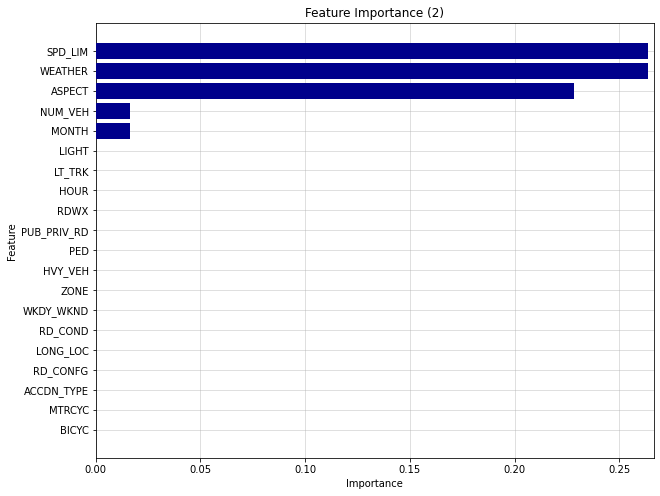

In [9]:
data: Type[process] = mtl_sev    
folds: Union[int,None] = 3
impute_strategy: Union[dict, None] = {'categorical': 'most_frequent', 'ordinal': 'constant', 'constant' : -1}
classifier: Union[DecisionTreeClassifier,
                  LogisticRegression, 
                  RandomForestClassifier,
                  XGBClassifier,] = DecisionTreeClassifier(max_depth=3, random_state=seed)
filename_stem: str = "mtl_sev"
model_dir: Path = path["models"]    
    
mtl_sev_dt = model(data=data, 
                    folds = folds,
                    impute_strategy=impute_strategy,
                    classifier=classifier,
                    filename_stem=filename_stem,
                    model_dir=model_dir,)

In [5]:
# Let's just try predicting whether or not an accident will involve at least one victim.

df: pd.DataFrame = collision_data["EN"]                 # Underlying dataframe (contains all data from all regions from 2011 to 2022).
region: Union[list, None] = ["Montréal (06)"]           # Restrict to this region (or these regions).
drop_row_if_missing_value_in: Union[list, None] = None  # We drop all rows for which there is a missing value in a column from this list.   
targets: list = ["VICTIMS"]                             # We intend to make predictions for values in each of these columns.
                                                        # Can add 'MULT_VEH', 'VICTIMS', and 'TNRY_SEV' to targets: columns will be inserted automatically.
non_features: list = ["ID", "YEAR"]  + targets
features: list = [c for c in df.columns                 # These are the features we will want to use to make predictions about the targets.
                  if c not in non_features] 
test_size: float = 0.1                                  # We'll partition what's left of the rows into train/test sets, with this as relative test set size.
                                                        # We'll also split the 'train' set later, either through k-fold cross-validation or, if not, train will be split 90/10 with the 10% share going to validation.
seed: int = 0                                           # Wherever there is randomness (e.g. during train/test split we'll shuffle), we'll use this seed.
stratify: bool = True                                   # If True, we'll perform a stratified train/test split.
stratify_by: Union[list, None] = targets
    
mtl_victims = process(df=df,
              region=region,
              drop_row_if_missing_value_in=drop_row_if_missing_value_in,
              targets=targets,
              features=features,
              test_size=test_size,
              seed=seed,
              stratify=stratify,
              stratify_by=stratify_by)    

Restricting to region(s): ['Montréal (06)'].
Inserting 'VICTIMS' column.
Removing 'REGION' from self.features (the only region is Montréal (06)).
Removing SEVERITY from self.features (but not from self.df): can't use SEVERITY to predict VICTIMS.
Removing NUM_VICTIMS from self.features (but not from self.df): can't use NUM_VICTIMS to predict VICTIMS.
Partitioning data into training/test sets: self.df_train/self.df_test.
self.ordinal_features = ['LIGHT', 'NUM_VEH', 'SPD_LIM']
self.ordinal_targets = ['VICTIMS']
self.categorical_features = ['WKDY_WKND', 'PUB_PRIV_RD', 'RD_COND', 'MTRCYC', 'ASPECT', 'PED', 'RDWX', 'MONTH', 'LT_TRK', 'LONG_LOC', 'RD_CONFG', 'BICYC', 'HOUR', 'HVY_VEH', 'ACCDN_TYPE', 'WEATHER', 'ZONE']
self.categorical_targets = []



SEPARATING FEATURES FROM TARGETS

self.X_train/self.X_test, self.y_train/self.y_test

MAPPING ORDINAL FEATURE/TARGET CODES

LIGHT: {1: 3, 2: 2, 3: 1, 4: 0}
NUM_VEH: {1: 0, 2: 1, 9: 2}
SPD_LIM: {'<50': 0, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9, 100: 10}
VICTIMS: {0: 0, 1: 1}

MAPPING CATEGORICAL FEATURE/TARGET CODES

WKDY_WKND: {'WKDY': 0, 'WKND': 1}
PUB_PRIV_RD: {1: 0, 2: 1}
RD_COND: {11: 0, 12: 1, 13: 2, 14: 3, 15: 4, 16: 5, 17: 6, 18: 7, 19: 8, 20: 9, 99: 10}
MTRCYC: {'N': 0, 'Y': 1}
ASPECT: {'Straight': 0, 'Curve': 1}
PED: {'N': 0, 'Y': 1}
RDWX: {'N': 0, 'Y': 1}
MONTH: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
LT_TRK: {'N': 0, 'Y': 1}
LONG_LOC: {12: 0, 33: 1, 34: 2, 40: 3, 69: 4, 99: 5}
RD_CONFG: {1: 0, 23: 1, 45: 2, 9: 3}
BICYC: {'N': 0, 'Y': 1}
HOUR: {'00:00:00-03:59:00': 0, '04:00:00-07:59:00': 1, '08:00:00-11:59:00': 2, '12:00:00-15:59:00': 3, '16:00:00-19:59:00': 4, '20:00:00-23:59:00': 5}
HVY_VEH: {'N': 0, 'Y': 1}
ACCDN_TYPE: {'vehicle': 0, 'pe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                              3],
                                                                             [0,
                                                                              1,
                                                                              2],
                                                                             [0,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10]],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['LIGHT', 'NUM_VEH',
                                                   'SPD_LIM']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['WKDY_WKND', 'PUB_PRIV_RD',
                                                   'RD_COND', 'MTRCYC',
                                                   'ASPECT', 'PED', 'RDWX',
                                                   'MONTH', '...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, nthread=-1,
                               num_parallel_tree=None, ...))])


      MAKING PREDICTIONS ON VALIDATION FOLD

CV 1: FITTING

      MAKING PREDICTIONS ON VALIDATION FOLD

CV 2: FITTING

      MAKING PREDICTIONS ON VALIDATION FOLD

Target, prediction, and probabilities for each validation fold stored in self.preds dictionary.

Feature importances corresponding to each validation fold stored in self.feature_importances dictionary.

SAVING PIPELINE: D:\projects\road-safety\models\mtl_victims_xgb.joblib

Metrics (including confusion matrices) contained in dictionary self.eval.
Metrics (excluding confusion matrices) also contained in dataframe self.eval_df


,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.861224,0.679189,0.861137,0.861224,0.838494,0.848975,0.508609,0.845284
1,0.859790,0.676696,0.859003,0.859790,0.836737,0.847420,0.502286,0.844782
2,0.861586,0.681195,0.860926,0.861586,0.839373,0.849617,0.510223,0.845726
mean,0.860867,0.679026,0.860356,0.860867,0.838201,0.848670,0.507040,0.845264



Prob(label | prediction = column heading)


Dropdown(options=(0, 1, 2), value=0)

Output()


Prob(prediction | label = row name)


Dropdown(options=(0, 1, 2), value=0)

Output()


Feature importances corresponding to validation set(s) contained in self.feature_importances and self.feature_importances_df.

FEATURE IMPORTANCE


interactive(children=(Dropdown(description='Sort by:', options=(0, 1, 2), value=0), Output()), _dom_classes=('…

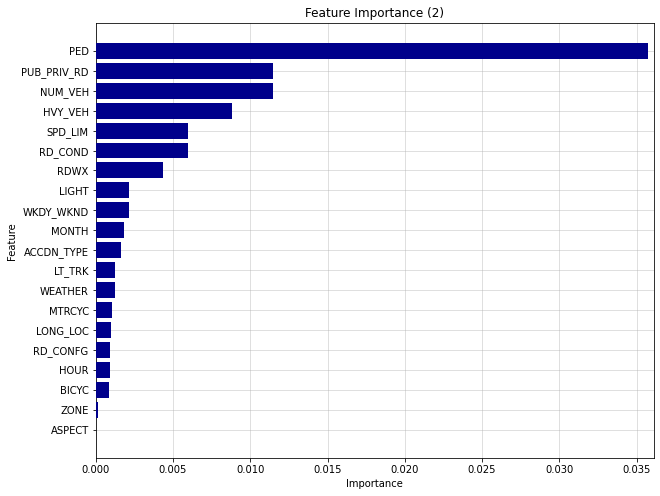

In [6]:
data: Type[process] = mtl_victims   
folds: Union[int,None] = 3
impute_strategy: Union[dict, None] = None #{'categorical': 'most_frequent', 'ordinal': 'constant', 'constant' : -1}
classifier: Union[DecisionTreeClassifier,
                  LogisticRegression, 
                  RandomForestClassifier,
                  XGBClassifier,] = XGBClassifier(objective='binary:logistic', eval_metric='logloss', nthread=-1)
filename_stem: str = "mtl_victims"
model_dir: Path = path["models"]    
    
mtl_victims_xgb = model(data=data, 
                    folds = folds,
                    impute_strategy=impute_strategy,
                    classifier=classifier,
                    filename_stem=filename_stem,
                    model_dir=model_dir,)

In [7]:
from models import model
from typing import Optional, Type, Union, Callable
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

data: Type[process] = mtl_sev    
folds: Union[int,None] = 3 # We'll do 5 or 10: this is just for testing the code (it takes time).
impute_strategy: Union[dict, None] = {'categorical': 'most_frequent', 'ordinal': 'constant', 'constant' : -1}
classifier: Union[DecisionTreeClassifier,
                  GradientBoostingClassifier,
                  LogisticRegression, 
                  RandomForestClassifier,
                  XGBClassifier,] = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=seed)
filename_stem: str = "mtl_sev"
model_dir: Path = path["models"]    
    
mtl_sev_gbm = model(data=data, 
                    folds = folds,
                    impute_strategy=impute_strategy,
                    classifier=classifier,
                    filename_stem=filename_stem,
                    model_dir=model_dir,)


SEPARATING FEATURES FROM TARGETS

self.X_train/self.X_test, self.y_train/self.y_test

MAPPING ORDINAL FEATURE/TARGET CODES

NUM_VEH: {1: 0, 2: 1, 9: 2}
LIGHT: {1: 3, 2: 2, 3: 1, 4: 0}
SPD_LIM: {'<50': 0, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9, 100: 10}
SEVERITY: {'Material damage below the reporting threshold': 0, 'Material damage only': 1, 'Minor': 2, 'Fatal or serious': 3}

MAPPING CATEGORICAL FEATURE/TARGET CODES

RD_CONFG: {1: 0, 23: 1, 45: 2, 9: 3}
MONTH: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
ASPECT: {'Straight': 0, 'Curve': 1}
HOUR: {'00:00:00-03:59:00': 0, '04:00:00-07:59:00': 1, '08:00:00-11:59:00': 2, '12:00:00-15:59:00': 3, '16:00:00-19:59:00': 4, '20:00:00-23:59:00': 5}
WEATHER: {12: 0, 13: 1, 14: 2, 15: 3, 16: 4, 17: 5, 18: 6, 19: 7, 99: 8}
LONG_LOC: {12: 0, 33: 1, 34: 2, 40: 3, 69: 4, 99: 5}
HVY_VEH: {'N': 0, 'Y': 1}
RDWX: {'N': 0, 'Y': 1}
LT_TRK: {'N': 0, 'Y': 1}
ZONE: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 9: 6}
ACCDN_TYPE: {'vehicle': 

KeyboardInterrupt: 